# DATA

In [2]:
TRAIN_FLAG = True
DATA_SET = 'Shapes' # 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.)

In [4]:
import torch
from torch.utils.data import Dataset
from pythae.data.datasets import DatasetOutput
from torchvision import datasets

class MNIST(Dataset):
    def __init__(self, data):
        self.data = data #.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return DatasetOutput(data=x)

In [ ]:
import glob
import numpy as np
from PIL import Image
from utils.data import sample_indices


def load_shapes_dataset(dirpath='/mnt/Shared/shapes'):
    x = []
    y = []

    label_dict = {
        'circles' : 0,
        'squares' : 1,
        'triangles' : 2
    }

    files = glob.glob(dirpath + '/**/*.png', recursive=True)

    for f in files:
        img=Image.open(f)
        img=img.resize(size=(28,28))
        img=img.convert('L')
        x.append(np.array(img))
        label = f.split('/')[-2]
        #y.append(label_dict[label])
        y.append(label)
        del img

    return np.array(x), np.array(y)

(300, 1, 28, 28)
{'circles': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'squares': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], 'triangles': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

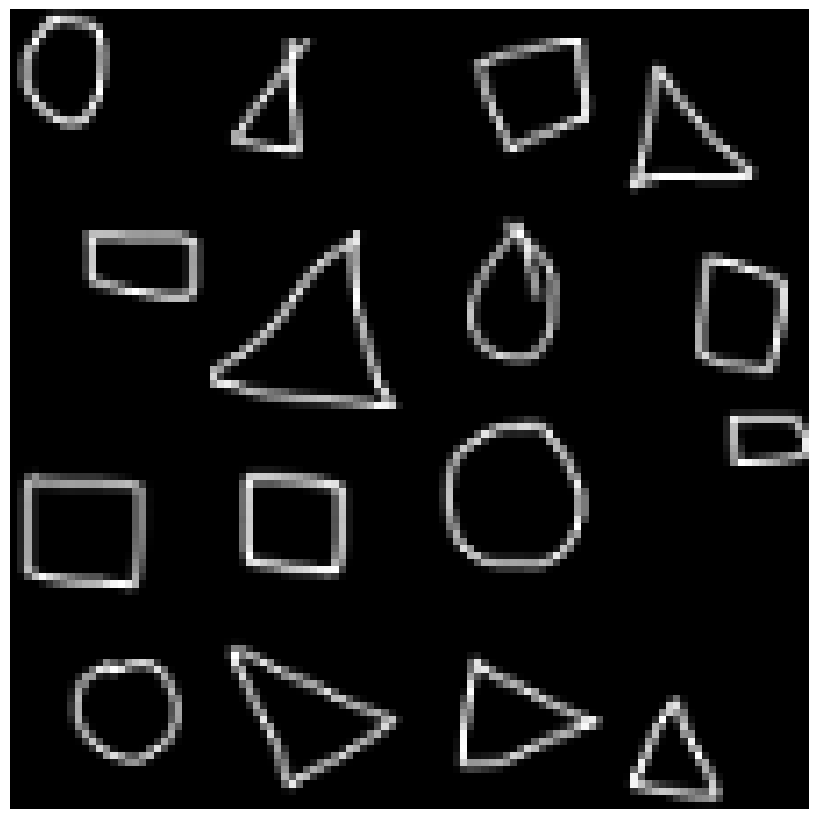

In [111]:
if DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)


    train_indeces = sample_indices(targets, k=90, seed=42)

    remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
        
    train_dataset = torch.from_numpy(shapes[train_indeces])
    eval_dataset = torch.from_numpy(shapes[test_indeces])


elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    train_indeces = sample_indices(mnist_trainset.targets, k=50, seed=42)

    remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=5, seed=42)

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)

In [50]:
import torch
from torch.utils.data import Dataset, ConcatDataset
from pythae.data.datasets import DatasetOutput


mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [51]:
from utils.data import sample_indices

train_indeces = sample_indices(mnist_trainset.targets, k=50, seed=42)

remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=5, seed=42)

In [74]:
train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.
print(train_dataset.shape, eval_dataset.shape)

NameError: name 'mnist_trainset' is not defined

In [36]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

In [ ]:
# train_dataset = MNIST(train_dataset)
# eval_dataset = MNIST(eval_dataset)

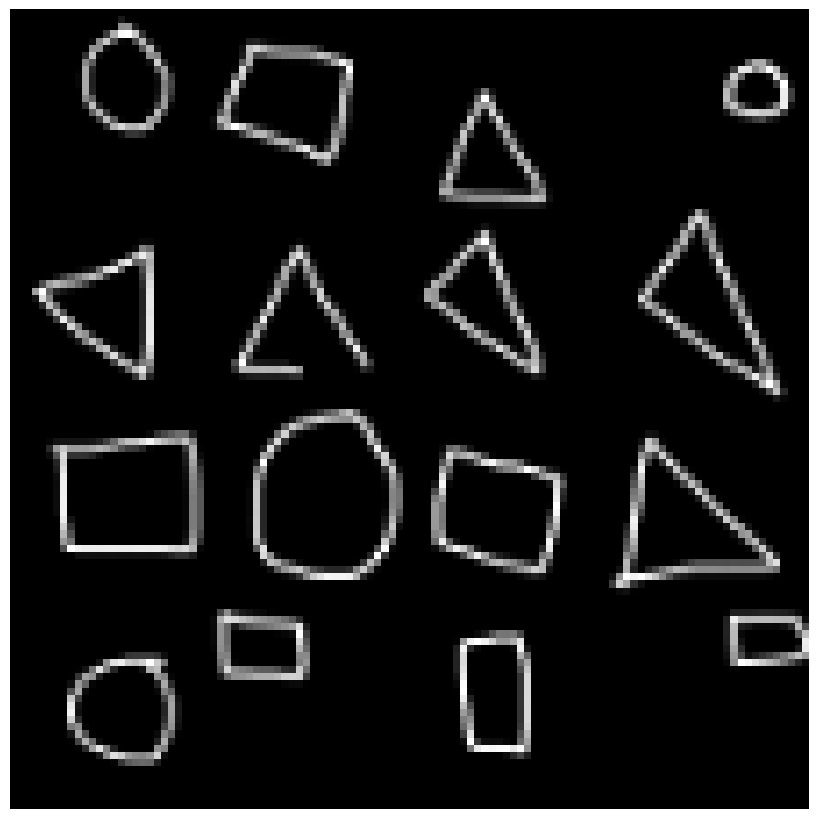

In [80]:
plot_grid(train_dataset.data)

# TRAIN

## Configure Training

In [129]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }


model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    reconstruction_loss="mse",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-2
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8,
)

model = VAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VAE_MNIST(model_config),
    decoder=Decoder_ResNet_AE_MNIST(model_config)
)

In [130]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 399 µs, sys: 7 µs, total: 406 µs
Wall time: 415 µs


717521

In [131]:
print(model)

VAE(
  (decoder): Decoder_ResNet_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=8, out_features=2048, bias=True)
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): ReLU()
      )
    

## Early Stopping

In [115]:
from pytorch_lightning.callbacks import EarlyStopping
# early_stop_cb = EarlyStopping(
#     monitor='val_loss',
#     min_delta=1e-5,
#     patience=3,
#     verbose=False,
#     mode='min')

from pythae.trainers.training_callbacks import *

class EarlyStopping(TrainingCallback):
    def __init__(self, patience=5, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_metric = np.Inf if mode == 'min' else -np.Inf
        self.counter = 0
        self.early_stop = False

    def on_eval_step_end(self, training_config: BaseTrainerConfig, **kwargs):
        logger = kwargs.pop("logger", self.logger)

        if logger is not None:
            current_metric = logger.get("eval_epoch_loss", None)

            if self.mode == 'min':
                improvement = current_metric < self.best_metric - self.min_delta
            else:
                improvement = current_metric > self.best_metric + self.min_delta

            if improvement:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

            return self.early_stop

early_stop_cb = EarlyStopping(
    min_delta=10,
    patience=0,
    mode='min')

callbacks = []
callbacks.append(early_stop_cb)

## Train

In [132]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=100,
    learning_rate=1e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    # optimizer_params={'weight_decay':1e-4},
    # scheduler_cls="ReduceLROnPlateau",
    # scheduler_params={"patience": 5, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/VAE_training_2024-05-27_18-46-54. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 270
 - per_device_eval_batch_size: 30
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.9385
Eval loss: 59.2297
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.6432
Eval loss: 47.0989
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.931
Eval loss: 38.3617
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.4295
Eval loss: 24.8836
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.8564
Eval loss: 18.2205
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 18.272
Eval loss: 14.2008
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 14.1525
Eval loss: 12.3778
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.2905
Eval loss: 11.5045
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.3129
Eval loss: 11.0906
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.8367
Eval loss: 10.9862
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.7301
Eval loss: 10.962
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.6923
Eval loss: 10.8823
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.6237
Eval loss: 10.8349
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5743
Eval loss: 10.863
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.6054
Eval loss: 10.8977
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.64
Eval loss: 10.8419
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5831
Eval loss: 10.8159
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5557
Eval loss: 10.8444
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5828
Eval loss: 10.8516
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5896
Eval loss: 10.8405
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5791
Eval loss: 10.8234
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5628
Eval loss: 10.8195
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5599
Eval loss: 10.8235
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5643
Eval loss: 10.8311
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5719
Eval loss: 10.8207
--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5609
Eval loss: 10.8166
--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5562
Eval loss: 10.8148
--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5542
Eval loss: 10.8184
--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5578
Eval loss: 10.8158
--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.555
Eval loss: 10.8157
--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5549
Eval loss: 10.8134
--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5532
Eval loss: 10.8125
--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5528
Eval loss: 10.8074
--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5476
Eval loss: 10.8096
--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5495
Eval loss: 10.8118
--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5516
Eval loss: 10.8116
--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5513
Eval loss: 10.8082
--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5477
Eval loss: 10.8075
--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.547
Eval loss: 10.8069
--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5467
Eval loss: 10.8074
--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5473
Eval loss: 10.8089
--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5485
Eval loss: 10.8077
--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5474
Eval loss: 10.8063
--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5461
Eval loss: 10.8052
--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5449
Eval loss: 10.8061
--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5457
Eval loss: 10.8065
--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5463
Eval loss: 10.8063
--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5461
Eval loss: 10.8058
--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5454
Eval loss: 10.8051
--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5449
Eval loss: 10.8052
--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5451
Eval loss: 10.805
--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5447
Eval loss: 10.8051
--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5448
Eval loss: 10.8055
--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5453
Eval loss: 10.8051
--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5447
Eval loss: 10.8048
--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5444
Eval loss: 10.8046
--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5443
Eval loss: 10.8046
--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5443
Eval loss: 10.8049
--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5446
Eval loss: 10.8046
--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5444
Eval loss: 10.8044
--------------------------------------------------------------------------


Training of epoch 61/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5443
Eval loss: 10.8045
--------------------------------------------------------------------------


Training of epoch 62/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5442
Eval loss: 10.8042
--------------------------------------------------------------------------


Training of epoch 63/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.544
Eval loss: 10.8043
--------------------------------------------------------------------------


Training of epoch 64/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.544
Eval loss: 10.8046
--------------------------------------------------------------------------


Training of epoch 65/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5442
Eval loss: 10.8044
--------------------------------------------------------------------------


Training of epoch 66/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5441
Eval loss: 10.8042
--------------------------------------------------------------------------


Training of epoch 67/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.544
Eval loss: 10.8042
--------------------------------------------------------------------------


Training of epoch 68/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5439
Eval loss: 10.8041
--------------------------------------------------------------------------


Training of epoch 69/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5439
Eval loss: 10.8041
--------------------------------------------------------------------------


Training of epoch 70/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5439
Eval loss: 10.8042
--------------------------------------------------------------------------


Training of epoch 71/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5439
Eval loss: 10.8042
--------------------------------------------------------------------------


Training of epoch 72/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5439
Eval loss: 10.8041
--------------------------------------------------------------------------


Training of epoch 73/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5439
Eval loss: 10.8041
--------------------------------------------------------------------------


Training of epoch 74/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5438
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 75/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5437
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 76/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5438
Eval loss: 10.8041
--------------------------------------------------------------------------


Training of epoch 77/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5438
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 78/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5438
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 79/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5437
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 80/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5437
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 81/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5437
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 82/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5437
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 83/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5437
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 84/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5437
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 85/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 86/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 87/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.804
--------------------------------------------------------------------------


Training of epoch 88/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 89/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 90/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 91/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 92/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 93/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 94/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 95/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 96/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 97/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 98/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5436
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 99/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5435
Eval loss: 10.8039
--------------------------------------------------------------------------


Training of epoch 100/100:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5435
Eval loss: 10.8039
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/VAE_training_2024-05-27_18-46-54/final_model


## Trained Model

In [134]:
from pythae.models import AutoModel

import glob

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])

# RECONSTRUCTIONS

In [118]:
reconstructions = trained_model.reconstruct(eval_dataset[:25]).detach().cpu()

# # show reconstructions
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         axes[i][j].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
#         axes[i][j].axis('off')
# plt.tight_layout(pad=0.)
plot_grid(reconstructions)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

# INTERPOLATIONS

In [120]:
interpolations = trained_model.interpolate(eval_dataset[:5], eval_dataset[5:10], granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

# GENERATE

### Normal Sampler

In [135]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

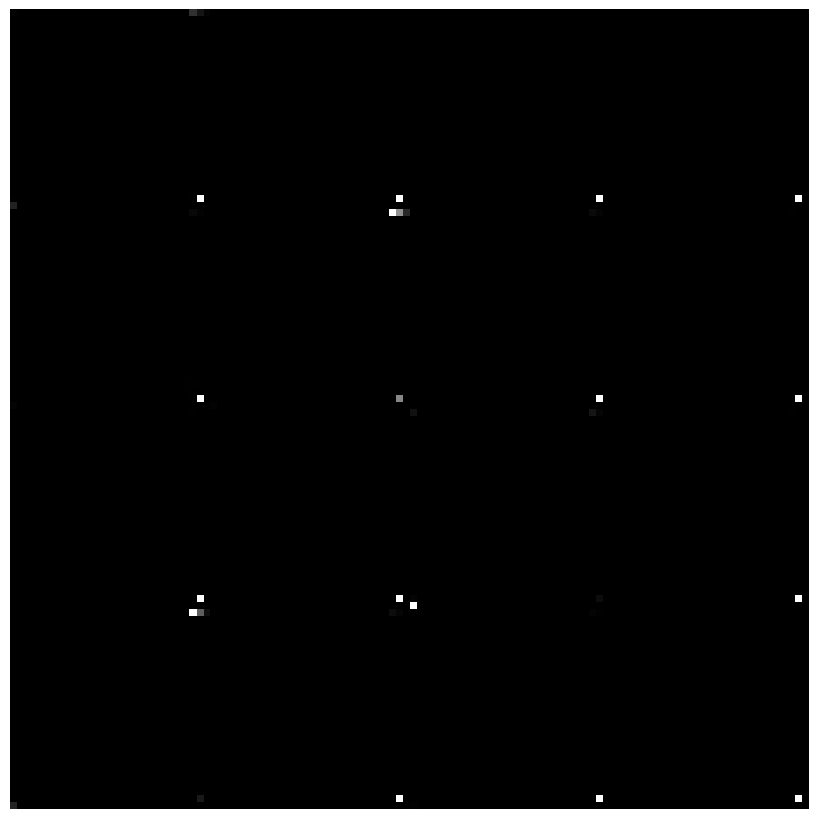

In [136]:
plot_grid(gen_data.data)

### Gaussian Mixture Model Sampler

In [137]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

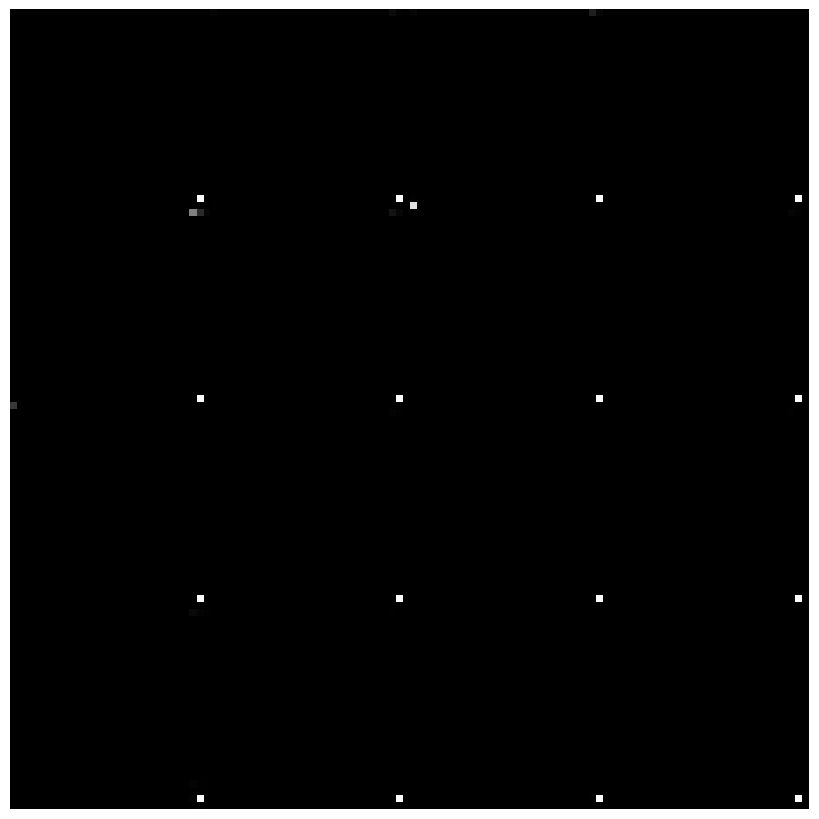

In [138]:
plot_grid(gmm_gen_data.data)

### RHVAE Sampler

In [139]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
    # mcmc_steps_nbr = 200,
    # n_lf = 3,
    # eps_lf = 1e-3,
    # beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

AttributeError: 'VAE' object has no attribute 'M_tens'

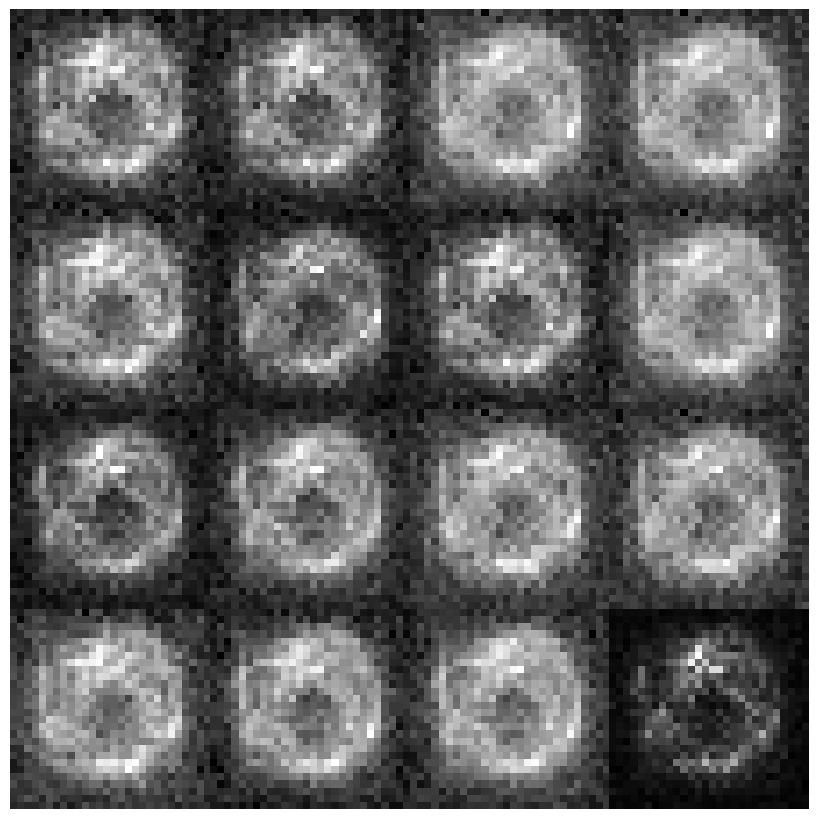

In [ ]:
plot_grid(rh_gen_data)

In [ ]:
rh_gen_data.shape

torch.Size([25, 1, 28, 28])

In [140]:
# #combined_dataset = ConcatDataset([train_dataset, rh_gen_data])
# combined_dataset = torch.cat((train_dataset, rh_gen_data), 0)
# combined_dataset = combined_dataset[torch.randperm(combined_dataset.size()[0])]
# combined_dataset.shape